### Find weights for NN using 3 local random search algorithms

In [1]:
import mlrose
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.dropna(inplace=True)
df.drop(columns='customerID', inplace=True)
df.Churn = df.Churn.map({'Yes':1, 'No':0})
df = pd.get_dummies(df)

df.shape

(7032, 46)

In [4]:
y = df.Churn.values
X = df.drop(columns='Churn')

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5274, 45) (1758, 45) (5274,) (1758,)


### Use MLP

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Anaconda2\envs\dva\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score, roc_auc_score, \
                            roc_curve, auc, scorer, classification_report, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, cross_val_predict, \
                             learning_curve, validation_curve

In [9]:
from sklearn.neural_network import MLPClassifier

In [315]:
%%time

model_mlp = MLPClassifier(random_state=1, early_stopping=True, hidden_layer_sizes=(300), verbose=10, 
                          max_iter=500, solver='adam', tol=0.000000001, validation_fraction=0.1)

model_mlp.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.56398622
Validation score: 0.789773
Iteration 2, loss = 0.45324793
Validation score: 0.806818
Iteration 3, loss = 0.43739613
Validation score: 0.810606
Iteration 4, loss = 0.42921790
Validation score: 0.816288
Iteration 5, loss = 0.42403521
Validation score: 0.795455
Iteration 6, loss = 0.42043160
Validation score: 0.804924
Iteration 7, loss = 0.41756190
Validation score: 0.821970
Iteration 8, loss = 0.41550515
Validation score: 0.810606
Iteration 9, loss = 0.41263074
Validation score: 0.808712
Iteration 10, loss = 0.41268962
Validation score: 0.814394
Iteration 11, loss = 0.41144260
Validation score: 0.808712
Iteration 12, loss = 0.40852230
Validation score: 0.812500
Iteration 13, loss = 0.40699102
Validation score: 0.812500
Iteration 14, loss = 0.40757730
Validation score: 0.806818
Iteration 15, loss = 0.40672671
Validation score: 0.808712
Iteration 16, loss = 0.40244576
Validation score: 0.814394
Iteration 17, loss = 0.40162534
Validation score: 0.816288
Iterat

In [316]:
pred = model_mlp.predict(X_test_scaled)
print(accuracy_score(y_test, pred))

0.8054607508532423


In [14]:
print(confusion_matrix(y_test, pred))

[[1179  115]
 [ 227  237]]


In [13]:
model_mlp

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=300, learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=1e-09,
       validation_fraction=0.1, verbose=10, warm_start=False)

### Find best learning rate (max_iters=200) and iterations for RHC/SA/GA

In [192]:
def find_lr(alg, lr):
    np.random.seed(1)
    m = mlrose.NeuralNetwork(hidden_nodes = [300], activation ='relu', 
                              algorithm = alg, 
                              max_iters = 200, bias = True, is_classifier = True, 
                              learning_rate = lr, early_stopping = True, 
                              clip_max = 10, max_attempts = 100)
    
    m.fit(X_train_scaled, y_train)
    p = m.predict(X_test_scaled)
    return accuracy_score(y_test, p)

In [193]:
%%time

lrs = [0.1, 1, 2, 3, 4, 5]
results_rhc = []

for lr in lrs:
    results_rhc.append(find_lr("random_hill_climb", lr))

Wall time: 1min 12s


In [194]:
%%time

lrs = [0.1, 1, 2, 3, 4, 5]
results_sa = []

for lr in lrs:
    results_sa.append(find_lr("simulated_annealing", lr))

Wall time: 1min 31s


In [195]:
%%time

lrs = [0.1, 1, 2, 3, 4, 5]
results_ga = []

for lr in lrs:
    results_ga.append(find_lr("genetic_alg", lr))

Wall time: 2h 19min 2s


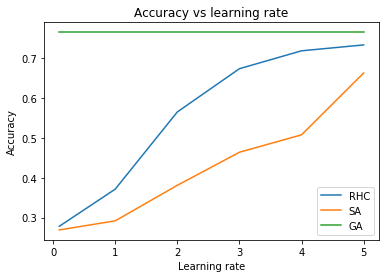

In [197]:
plt.plot(lrs, results_rhc, label='RHC')
plt.plot(lrs, results_sa, label='SA')
plt.plot(lrs, results_ga, label='GA')
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs learning rate")
plt.legend()

In [201]:
def find_iters(alg, m_iters, lr):
    np.random.seed(1)
    m = mlrose.NeuralNetwork(hidden_nodes = [300], activation ='relu', 
                              algorithm = alg, 
                              max_iters = m_iters, bias = True, is_classifier = True, 
                              learning_rate = lr, early_stopping = False, 
                              clip_max = 10, max_attempts = 100)
    
    m.fit(X_train_scaled, y_train)
    p = m.predict(X_test_scaled)
    return accuracy_score(y_test, p)

In [202]:
%%time

iters = range(10, 1000, 100)
scores_rhc = []
for iter in iters:
    scores_rhc.append(train_alg("random_hill_climb", iter, 2.6))

Wall time: 5min 25s


In [203]:
%%time

iters = range(10, 1000, 100)
scores_sa = []
for iter in iters:
    scores_sa.append(train_alg("simulated_annealing", iter, 2.6))

Wall time: 6min 43s


In [206]:
%%time

iters = range(10, 1000, 100)
scores_ga = []
for iter in iters:
    scores_ga.append(train_alg("genetic_alg", iter, 2.6))

Wall time: 12h 15min 45s


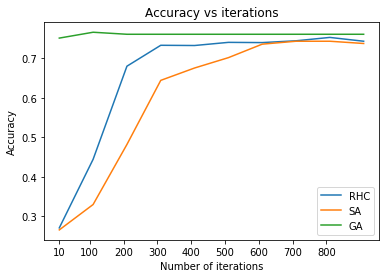

In [210]:
plt.plot(iters, scores_rhc, label='RHC')
plt.plot(iters, scores_sa, label='SA')
plt.plot(iters, scores_ga, label='GA')
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy vs iterations")
plt.xticks([10, 100, 200, 300, 400, 500, 600, 700, 800])
plt.legend()

### Set early_stopping True for all 3 algorithm

In [318]:
%%time

np.random.seed(1)

model1 = mlrose.NeuralNetwork(hidden_nodes = [300], activation ='relu', 
                              algorithm ='random_hill_climb', 
                              max_iters = 500, bias = True, is_classifier = True, 
                              early_stopping = True, learning_rate = 2.5,
                              clip_max = 10, max_attempts = 100)

model1.fit(X_train_scaled, y_train)

pred = model1.predict(X_test_scaled)
print(accuracy_score(y_test, pred))

0.7599544937428896
Wall time: 32.4 s


In [22]:
print(confusion_matrix(y_test, pred))

[[1093  201]
 [ 221  243]]


In [314]:
%%time

np.random.seed(1)

model2 = mlrose.NeuralNetwork(hidden_nodes = [300], activation ='relu', 
                              algorithm ='simulated_annealing', 
                              max_iters = 500, bias = True, is_classifier = True, 
                              learning_rate = 2.6, early_stopping = True, 
                              clip_max = 10, max_attempts = 100)

model2.fit(X_train_scaled, y_train)

pred = model2.predict(X_test_scaled)
print(accuracy_score(y_test, pred))

0.7110352673492605
Wall time: 40.1 s


In [31]:
print(confusion_matrix(y_test, pred))

[[1091  203]
 [ 305  159]]


In [319]:
%%time

np.random.seed(1)

model3 = mlrose.NeuralNetwork(hidden_nodes = [300], activation ='relu', 
                              algorithm ='genetic_alg', 
                              max_iters = 500, bias = True, is_classifier = True, 
                              early_stopping = True, 
                              clip_max = 10, max_attempts = 100)

model3.fit(X_train_scaled, y_train)

pred = model3.predict(X_test_scaled)
print(accuracy_score(y_test, pred))

0.7656427758816837
Wall time: 28min 11s


In [320]:
print(confusion_matrix(y_test, pred))

[[1205   89]
 [ 323  141]]


### Plot ROC curve

Text(0.5, 0, 'False Positive Rate')

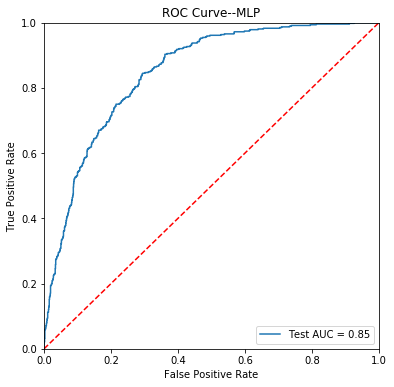

In [230]:
preds_test = model_mlp.predict_proba(X_test_scaled)[:,1]
fpr_test, tpr_test, threshold_test = roc_curve(y_test, preds_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(6, 6))
plt.title('ROC Curve--' + 'MLP')
plt.plot(fpr_test, tpr_test, label = 'Test AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [231]:
def plot_roc_curve(model, test, modelname):
    
    preds_test = model.predicted_probs
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, preds_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(6, 6))
    plt.title('ROC Curve--' + modelname)
    plt.plot(fpr_test, tpr_test, label = 'Test AUC = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

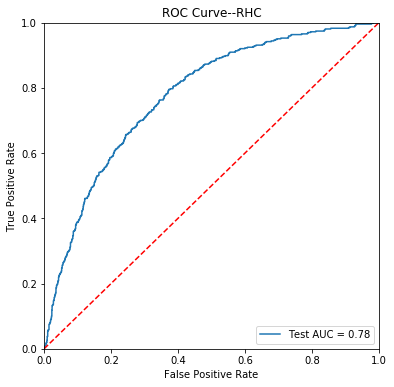

In [232]:
plot_roc_curve(model1, X_test_scaled, 'RHC')

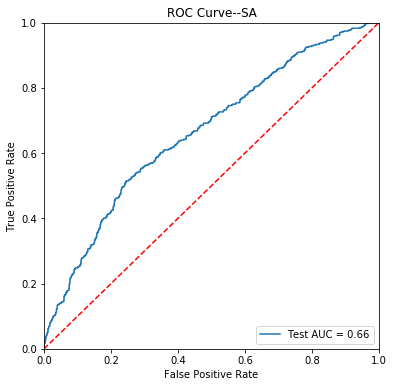

In [233]:
plot_roc_curve(model2, X_test_scaled, 'SA')

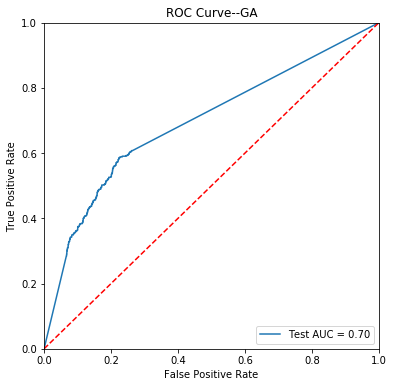

In [234]:
plot_roc_curve(model3, X_test_scaled, 'GA')

### Plot confusion matrix

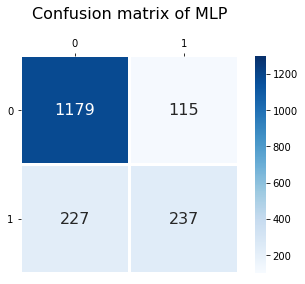

In [349]:
array = [[1179,  115],
         [ 227,  237]]

ax = sns.heatmap(array, annot=True, annot_kws={"size": 16}, fmt='.0f', cmap="Blues", linewidth=2, 
                 square=True, vmin=100, vmax=1300)
plt.title('Confusion matrix of MLP', fontdict={'fontsize':16}, pad=20)
plt.yticks(rotation=0)
ax.xaxis.tick_top()

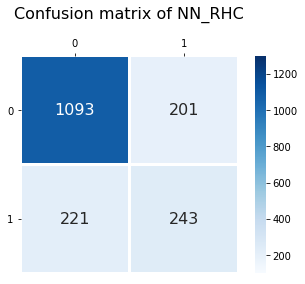

In [348]:
array = [[1093,  201],
         [ 221,  243]]

ax = sns.heatmap(array, annot=True, annot_kws={"size": 16}, fmt='.0f', cmap="Blues", linewidth=2, 
                 square=True, vmin=100, vmax=1300)
plt.title('Confusion matrix of NN_RHC', fontdict={'fontsize':16}, pad=20)
plt.yticks(rotation=0)
ax.xaxis.tick_top()

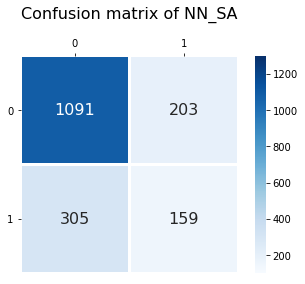

In [347]:
array = [[1091,  203],
         [ 305,  159]]

ax = sns.heatmap(array, annot=True, annot_kws={"size": 16}, fmt='.0f', cmap="Blues", linewidth=2, 
                 square=True, vmin=100, vmax=1300)
plt.title('Confusion matrix of NN_SA', fontdict={'fontsize':16}, pad=20)
plt.yticks(rotation=0)
ax.xaxis.tick_top()

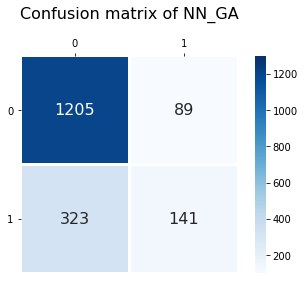

In [346]:
array = [[1205,   89],
         [ 323,  141]]

ax = sns.heatmap(array, annot=True, annot_kws={"size": 16}, fmt='.0f', cmap="Blues", linewidth=2, 
                 square=True, vmin=100, vmax=1300)
plt.title('Confusion matrix of NN_GA', fontdict={'fontsize':16}, pad=20)
plt.yticks(rotation=0)
ax.xaxis.tick_top()

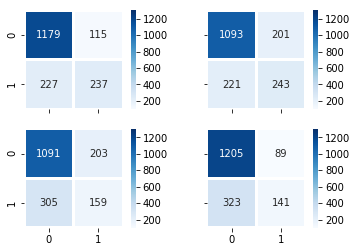

In [335]:
arrays = [[[1179,  115],
         [ 227,  237]],
         [[1093,  201],
         [ 221,  243]],
         [[1091,  203],
         [ 305,  159]],
         [[1205,   89],
         [ 323,  141]]]

array = [[1179,  115],
         [ 227,  237]]
fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)

for i, ax in enumerate(axn.flat):
    sns.heatmap(arrays[i], annot=True, fmt='.0f', cmap="Blues", linewidth=2, square=True, ax=ax, vmin=100, vmax=1300)

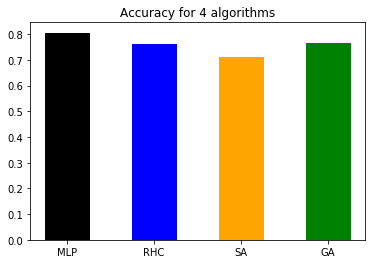

In [325]:
accuracy = {'MLP':0.8054607508532423, 'RHC':0.7599544937428896, 'SA':0.7110352673492605, 'GA':0.7656427758816837}
lists = accuracy.items()
x, y = zip(*lists)
plt.title('Accuracy for 4 algorithms')
barlist = plt.bar(x, y, width=0.5)
barlist[0].set_color('k')
barlist[1].set_color('b')
barlist[2].set_color('orange')
barlist[3].set_color('g')

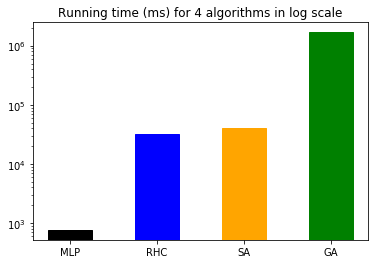

In [328]:
time = {'MLP':763, 'RHC':32400, 'SA':40100, 'GA':1691000}
lists = time.items() # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.title('Running time (ms) for 4 algorithms in log scale')
barlist = plt.bar(x, y, width=0.5, log=True)
barlist[0].set_color('k')
barlist[1].set_color('b')
barlist[2].set_color('orange')
barlist[3].set_color('g')